<a href="https://colab.research.google.com/github/sajib006/Route-Optimization/blob/main/Route_Optimizationub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install geopy shapely rtree fiona pyproj osmnx

In [ ]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 w

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2


In [ ]:
city = "Dhaka"
dtf=pd.read_csv('dhaka_stores_10.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 9


,id,City,Street Address,y,x
0,0,Dhaka,"House 72, Road 4, Tejgaon",23.701663,90.426323
1,1,Dhaka,"House 86, Road 3, Lalmatia",23.729484,90.391587
2,2,Dhaka,"House 53, Road 18, Kakrail",23.716499,90.400021


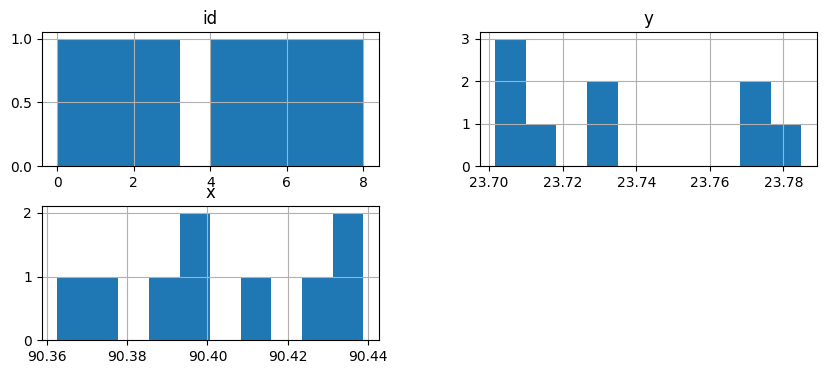

In [ ]:
dtf.hist(figsize=(10,4))
plt.show()

In [ ]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [23.701663 90.426323]


In [ ]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

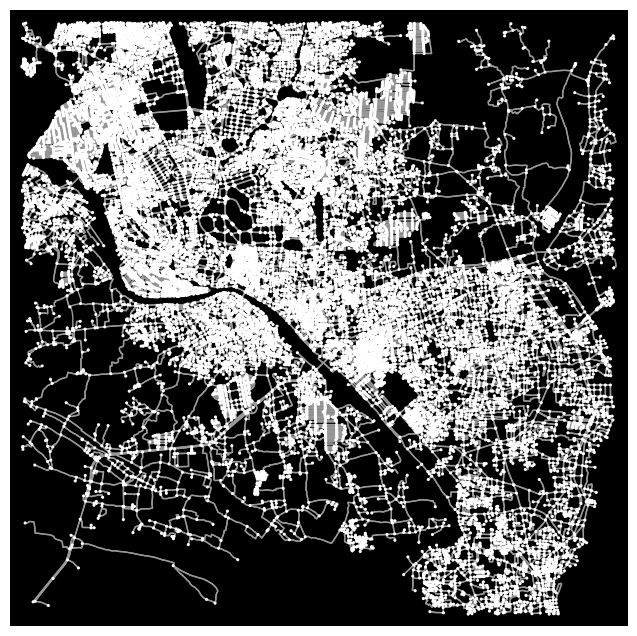

In [ ]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [ ]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

/tmp/ipython-input-2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
/tmp/ipython-input-2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
/tmp/ipython-input-2197898139.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt

,id,City,Street Address,y,x,node
0,0,Dhaka,"House 72, Road 4, Tejgaon",23.701663,90.426323,3304767702
1,1,Dhaka,"House 86, Road 3, Lalmatia",23.729484,90.391587,3006693671
2,2,Dhaka,"House 53, Road 18, Kakrail",23.716499,90.400021,2492202544
3,3,Dhaka,"House 192, Road 9, Jatrabari",23.770246,90.398125,4472197365
4,4,Dhaka,"House 156, Road 15, Lalmatia",23.773578,90.434756,4889208725


In [ ]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,3304767702,3006693671,2492202544,4472197365,4889208725,3739988771,12732370192,10559233158,4879928428
3304767702,0.000000,460.812631,375.604348,777.442423,959.000616,896.473267,380.396127,836.361098,318.998830
3006693671,491.052553,0.000000,175.718644,437.575418,750.749450,518.121086,189.445099,751.811432,523.116566
2492202544,369.109804,175.761556,0.000000,557.567331,823.829325,638.112998,245.224836,620.258873,441.675018
4472197365,855.688701,484.912613,604.861613,0.000000,551.955938,347.902753,507.621692,1161.092678,859.180694
4889208725,872.915346,665.082089,734.365815,525.544788,0.000000,776.185400,572.318334,1260.856252,876.407338


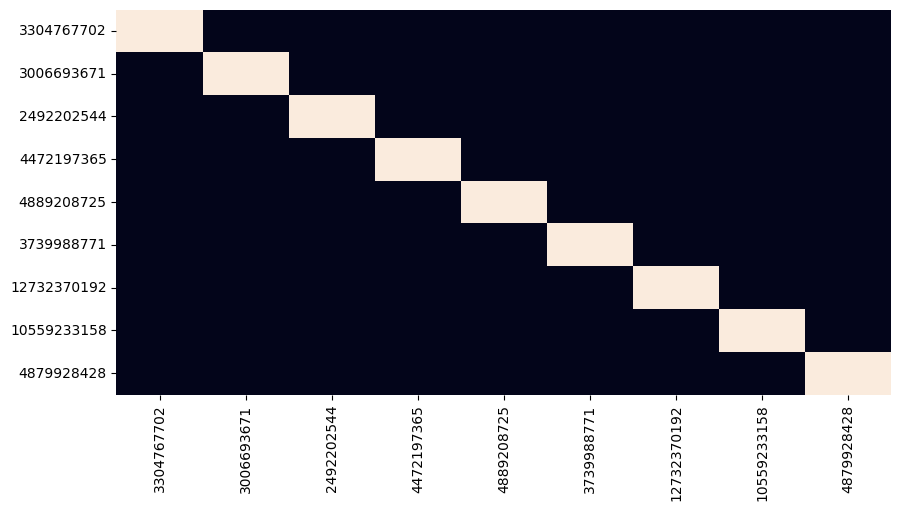

In [ ]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [ ]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,3304767702,3006693671,2492202544,4472197365,4889208725,3739988771,12732370192,10559233158,4879928428
3304767702,0,461,376,777,959,896,380,836,319
3006693671,491,0,176,438,751,518,189,752,523
2492202544,369,176,0,558,824,638,245,620,442
4472197365,856,485,605,0,552,348,508,1161,859
4889208725,873,665,734,526,0,776,572,1261,876
3739988771,971,571,691,403,843,0,616,1170,1003
12732370192,382,221,255,455,619,596,0,754,407
10559233158,845,812,647,1144,1326,1154,747,0,918
4879928428,324,462,428,759,923,898,382,888,0


In [ ]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 3304767702 total locations to visit 8 drivers 1


In [ ]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [ ]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [ ]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

Exception ignored in garbage collection:
Traceback (most recent call last):
  File "/tmp/ipython-input-2881824341.py", line 2, in get_distance
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexing.py", line 303, in iloc
    return _iLocIndexer("iloc", self)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
SystemError: <class 'pandas.core.indexing._iLocIndexer'> returned a result with an exception set


route for driver:
[0, 6, 8, 1, 2, 3, 5, 4, 7]
Total distance:4.43km
Nodes visited: 9


In [ ]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[3304767702, 12732370192, 4879928428, 3006693671, 2492202544, 4472197365, 3739988771, 4889208725, 10559233158]


In [ ]:
import folium

# ---- Step 1: Graph center বের করা ----
nodes = list(G.nodes())
lats = [G.nodes[n]['y'] for n in nodes]
lons = [G.nodes[n]['x'] for n in nodes]

center_lat = sum(lats) / len(lats)
center_lon = sum(lons) / len(lons)

# ---- Step 2: Create Folium map ----
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# ---- Step 3: Convert node path → coordinates ----
def nodes_to_coords(G, path):
    coords = []
    for n in path:
        lat = G.nodes[n]['y']
        lon = G.nodes[n]['x']
        coords.append((lat, lon))
    return coords

# ---- Step 4: Plot all routes ----
for path in lst_paths:
    coords = nodes_to_coords(G, path)
    folium.PolyLine(
        locations=coords,
        color="blue",
        weight=3,
        opacity=0.8
    ).add_to(m)

m


In [ ]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df


In [ ]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [ ]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig



In [ ]:
from geopy.distance import geodesic

# Node coordinates (lat, lon)
coords = list(zip(df['start_y'], df['start_x']))

# Empty list for distances between consecutive nodes
node_distances = []

for i in range(len(coords)-1):
    dist = geodesic(coords[i], coords[i+1]).km  # distance in km
    node_distances.append(dist)

# Add distances to the DataFrame (optional)
df['next_node_distance_km'] = node_distances + [0]  # last node distance = 0

print(df[['start_x','start_y','next_node_distance_km']])


       start_x    start_y  next_node_distance_km
0    90.426376  23.701361               0.033372
1    90.426049  23.701352               0.049421
2    90.425565  23.701334               0.092835
3    90.424656  23.701294               0.077093
4    90.423900  23.701270               0.082010
..         ...        ...                    ...
592  90.438938  23.703827               0.082472
593  90.438766  23.704554               0.007432
594  90.438838  23.704560               0.096079
595  90.438602  23.705400               0.050516
596  90.438463  23.705838               0.000000

[597 rows x 3 columns]


In [ ]:
from geopy.distance import geodesic

# ধরো node1 এবং node2
node1 = (23.701663,	90.426323)  # start_y, start_x
node2 = (23.729484,	90.391587)  # start_y, start_x

# distance in kilometers
distance_km = geodesic(node1, node2).km

print("Distance between nodes (km):", distance_km)


Distance between nodes (km): 4.694821662774358
